In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.expand_frame_repr', False)

### <center> **Data Loading**

In [2]:
okx = pd.read_csv(r'C:\Users\trgrd\OneDrive\Trading\Projects\funding_arb\code\okx_swaprate_data\combined\allswaprate_2024-02-01_to_2025-02-01_raw.csv')
print(okx)

       instrument_name contract_type  funding_rate  real_funding_rate   funding_time  fetch_date
0       EGLD-USDT-SWAP          SWAP     -0.000705           0.000159  1706745600000  2024-02-01
1        JOE-USDT-SWAP          SWAP     -0.000513           0.000108  1706745600000  2024-02-01
2       COMP-USDT-SWAP          SWAP     -0.000272           0.000074  1706745600000  2024-02-01
3        FXS-USDT-SWAP          SWAP     -0.000641           0.000080  1706745600000  2024-02-01
4        ARB-USDT-SWAP          SWAP     -0.000188           0.000091  1706745600000  2024-02-01
...                ...           ...           ...                ...            ...         ...
258870    LTC-USD-SWAP          SWAP      0.000087           0.000135  1738368000000  2025-02-01
258871   LRC-USDT-SWAP          SWAP      0.000120           0.000107  1738368000000  2025-02-01
258872   YGG-USDT-SWAP          SWAP      0.000111           0.000082  1738368000000  2025-02-01
258873    UNI-USD-SWAP        

We must align the timestamps between OKX and Binance

In [3]:
def get_okx_funding_symbol(symbol, okx_df):
    """
    Filter the OKX DataFrame for a given symbol and prepare it for alignment.
    """
    df = okx_df[okx_df['instrument_name'] == symbol].copy()
    # Convert from ms to datetime, set as index
    df['funding_time'] = pd.to_datetime(df['funding_time'], unit='ms', utc=True)
    df.set_index('funding_time', inplace=True)
    df.sort_index(inplace=True)
    # Clean up real_funding_rate
    df['real_funding_rate'] = pd.to_numeric(df['real_funding_rate'], errors='coerce')
    return df

def prepare_funding_times(binance_df, okx_df):
    """
    Align Binance and OKX funding data on exact 8-hour intervals (00:00, 08:00, 16:00 UTC).
    """
    def round_to_8h(ts):
        # If 0 <= ts <= 7, ts.hour // 8 * 8 = 0
        hour_block = (ts.hour // 8) * 8
        return pd.Timestamp(ts.year, ts.month, ts.day, hour_block)

    # Process OKX data
    okx_df = okx_df.copy()
    if 'funding_time' in okx_df.columns:
        okx_df['funding_time'] = pd.to_datetime(okx_df['funding_time'], unit='ms', utc=True)
        okx_df['funding_time'] = okx_df['funding_time'].dt.tz_localize(None)
        okx_df.set_index('funding_time', inplace=True)
    else:
        okx_df.index = pd.to_datetime(okx_df.index)
    okx_df['funding_8h'] = okx_df.index.to_series().apply(round_to_8h)

    # Process Binance data
    binance_df = binance_df.copy()
    binance_df.index = pd.to_datetime(binance_df.index)
    binance_df['funding_8h'] = binance_df.index.to_series().apply(round_to_8h)

    # Group by funding_8h blocks
    okx_aligned = okx_df.groupby('funding_8h')['real_funding_rate'].mean().rename('okx_rate')
    binance_aligned = binance_df.groupby('funding_8h')['fundingRate'].mean().rename('binance_rate')

    # Merge and compute funding differential
    aligned = pd.concat([binance_aligned, okx_aligned], axis=1).dropna()
    aligned['funding_diff'] = aligned['okx_rate'] - aligned['binance_rate']
    aligned['abs_diff'] = aligned['funding_diff'].abs()
    return aligned

def load_binance_data(symbols):
    """
    Load Binance funding rate data for each symbol in 'symbols' from parquet files.
    """
    data_map = {}
    for sym in symbols:
        path = f"./data/binance_funding_rate_{sym}.parquet"
        df = pd.read_parquet(path)
        df.set_index('fundingTime', inplace=True)
        df['fundingRate'] = pd.to_numeric(df['fundingRate'], errors='coerce')
        data_map[sym] = df
    return data_map

Let's pick some liquid coins and analyze them

In [4]:
okx_symbols = ["BTC-USDT-SWAP", "ETH-USDT-SWAP", "XRP-USDT-SWAP", "SOL-USDT-SWAP",
               "BNB-USDT-SWAP", "ADA-USDT-SWAP", "AVAX-USDT-SWAP", "LTC-USDT-SWAP"]
binance_symbols = ['BTCUSDT', 'BNBUSDT', 'ETHUSDT', 'SOLUSDT',
                   'XRPUSDT', 'ADAUSDT', 'LTCUSDT', 'AVAXUSDT']

binance_data = load_binance_data(binance_symbols)

Some symbols have less data than the others. We must account for this, so we limit the range of all symbols to cover the range of the ones with least data

In [5]:
# Align Each Symbol
symbols_data = {}
all_aligned_dfs = []

for sym_okx in okx_symbols:
    base_name = sym_okx.replace('-USDT-SWAP', '')
    binance_sym_key = base_name + 'USDT'

    # Get the OKX data for given symbol
    okx_sym_df = get_okx_funding_symbol(sym_okx, okx)

    # Corresponding Binance data
    if binance_sym_key not in binance_data:
        print(f"Warning: No Binance data for {binance_sym_key}")
        continue
    binance_df = binance_data[binance_sym_key].copy()

    # 8-hour snapping alignment
    aligned_sym = prepare_funding_times(binance_df, okx_sym_df)
    symbols_data[sym_okx] = aligned_sym
    all_aligned_dfs.append(aligned_sym)

# Find the symbol with the fewest observations
min_samples = min(len(df) for df in all_aligned_dfs)
reference_df = next(df for df in all_aligned_dfs if len(df) == min_samples)

# Use the reference dataframe's dates to filter all other symbols
reference_dates = reference_df.index

# Limit all symbols to the same date range
for sym in symbols_data:
    # Filter to only include the dates from the reference dataframe
    symbols_data[sym] = symbols_data[sym].loc[symbols_data[sym].index.isin(reference_dates)]

Let's inspect the top coins and look at their basis point differentials 

In [6]:
coin_stats = []
for sym, df in symbols_data.items():
    df_stats = {
        'symbol': sym,
        'mean_abs_diff': df['abs_diff'].mean() * 10_000,   # convert to bps
        'std_abs_diff': df['abs_diff'].std() * 10_000,
        'max_abs_diff': df['abs_diff'].max() * 10_000,
        'q95_abs_diff': df['abs_diff'].quantile(0.95) * 10_000,
        'num_samples': len(df)
    }
    coin_stats.append(df_stats)

coin_stats_df = pd.DataFrame(coin_stats).sort_values('mean_abs_diff', ascending=False)
print(coin_stats_df)

           symbol  mean_abs_diff  std_abs_diff  max_abs_diff  q95_abs_diff  num_samples
6  AVAX-USDT-SWAP       1.044051      0.919276     12.852956      2.528703          738
4   BNB-USDT-SWAP       0.882493      1.043432      8.766320      2.721408          735
2   XRP-USDT-SWAP       0.852999      0.682480      3.694456      2.206770          738
5   ADA-USDT-SWAP       0.849614      0.779221      5.697101      2.294245          738
3   SOL-USDT-SWAP       0.782251      0.818532     12.270081      2.010198          738
7   LTC-USDT-SWAP       0.695959      0.611642      4.085062      1.861144          738
0   BTC-USDT-SWAP       0.672708      0.693162      7.234325      1.657242          735
1   ETH-USDT-SWAP       0.641969      0.629499      8.601014      1.612583          738


We see the top pairs here are `AVAXUSDT` `BNBUSDT`, `XRPUSDT` and . We proceed with analyzing **BNB/USDT**.

To do that, we need to compute some break-even points. We do this with fees that we have to test. Assuming access to some of the best fees, we will look at profitability given that we have access to that, but also given that we do not have access to that. This helps us see the importance of actual trading fees.

We will assume that break-evens are the duration/number of cash flow intervals, 8 hour intervals, required to cover the cost of entry.

This is an important figure, since we are paid future differentials.

In [7]:
# Binance fees
binance_fees_maker = [
    0.0200,  # Regular User
    0.0160,  # VIP 1
    0.0140,  # VIP 2
    0.0120,  # VIP 3
    0.0100,  # VIP 4
    0.0080,  # VIP 5
    0.0060,  # VIP 6
    0.0040,  # VIP 7
    0.0020,  # VIP 8
    0.0000,  # VIP 9
]

binance_fees_taker = [
    0.0500,  # Regular User
    0.0400,  # VIP 1
    0.0350,  # VIP 2
    0.0320,  # VIP 3
    0.0300,  # VIP 4
    0.0270,  # VIP 5
    0.0250,  # VIP 6
    0.0220,  # VIP 7
    0.0200,  # VIP 8
    0.0170,  # VIP 9
]

# OKX fees
okx_fees_maker = [
    0.080,   # Regular User
    0.045,   # VIP 1
    0.040,   # VIP 2
    0.030,   # VIP 3
    0.020,   # VIP 4
    0.000,   # VIP 5
   -0.002,   # VIP 6
   -0.005,   # VIP 7
   -0.005    # VIP 8
]

okx_fees_taker = [
    0.100,   # Regular User
    0.050,   # VIP 1
    0.045,   # VIP 2
    0.040,   # VIP 3
    0.035,   # VIP 4
    0.030,   # VIP 5
    0.025,   # VIP 6
    0.020,   # VIP 7
    0.015    # VIP 8
]

### <center> **Break-even Points**

We have that $ T_\text{cost} = 2 \cdot f \cdot Q $ and the revenue per interval, $ \text{Profit} = |\Delta_F| \cdot Q $. Hence, the total revenue is $ |\Delta_F| \cdot Q \cdot n $. Setting these equal and dividing both sides by the position size, followed by solving for number of intervals, we get that the amount of intervals needed for break-even is
$$
    n = \frac{2 f}{|\Delta_F|}.
$$

This means that if the funding differential is small, we need more intervals to accumulate enough revenue. Conversely, if the funding differential is large, we break even much faster.

In [8]:
def calculate_breakevens(mean_funding_diff, fee_schedules):
    """
    Calculate how many funding intervals needed to cover fees.
    """
    binance_maker = fee_schedules['binance_maker']
    binance_taker = fee_schedules['binance_taker']
    okx_maker = fee_schedules['okx_maker']
    okx_taker = fee_schedules['okx_taker']

    # Convert mean funding diff from bps to decimal
    funding_diff_pct = mean_funding_diff / 10_000
    breakevens = []

    for i in range(min(len(binance_maker), len(okx_maker))):
        total_fees_maker_taker = (binance_maker[i] + okx_taker[i]) / 100
        total_fees_taker_maker = (binance_taker[i] + okx_maker[i]) / 100

        if funding_diff_pct > 0:
            be_maker_taker = (2 * total_fees_maker_taker) / funding_diff_pct
            be_taker_maker = (2 * total_fees_taker_maker) / funding_diff_pct
        else:
            be_maker_taker = float('inf')
            be_taker_maker = float('inf')

        breakevens.append({
            'vip_level': i,
            'be_maker_taker': be_maker_taker,
            'be_taker_maker': be_taker_maker,
            'total_fees_maker_taker': total_fees_maker_taker,
            'total_fees_taker_maker': total_fees_taker_maker
        })

    return breakevens

In [9]:
fee_schedules = {
    'binance_maker': binance_fees_maker,
    'binance_taker': binance_fees_taker,
    'okx_maker': okx_fees_maker,
    'okx_taker': okx_fees_taker
}

bnb_mean_abs_diff = coin_stats_df.loc[coin_stats_df["symbol"] == 'BNB-USDT-SWAP', 'mean_abs_diff'].iloc[0]
bnb_breakevens = calculate_breakevens(bnb_mean_abs_diff, fee_schedules)

vip_levels = [be['vip_level'] for be in bnb_breakevens]
maker_taker_be = [be['be_maker_taker'] for be in bnb_breakevens]
taker_maker_be = [be['be_taker_maker'] for be in bnb_breakevens]

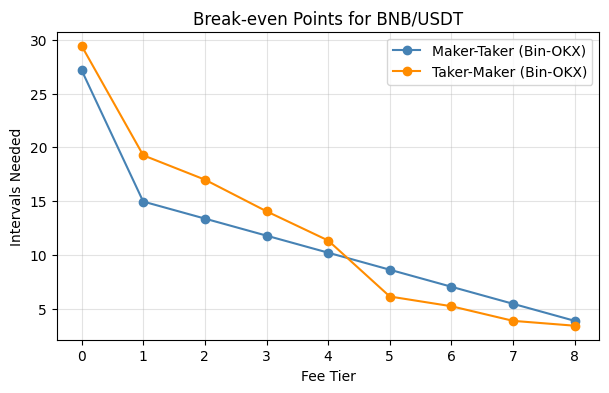

In [10]:
plt.figure(figsize=(7, 4))
plt.plot(vip_levels, maker_taker_be, 'o-', label='Maker-Taker (Bin-OKX)', color='steelblue')
plt.plot(vip_levels, taker_maker_be, 'o-', label='Taker-Maker (Bin-OKX)', color='darkorange')
plt.xlabel('Fee Tier')
plt.ylabel('Intervals Needed')
plt.title('Break-even Points for BNB/USDT')
plt.legend()
plt.grid(alpha=0.35)
# plt.savefig('break-even_fees.pdf', format='pdf')
plt.show()

We clearly see how important the trading fees are in this strategy. If we do not have optimal fees, we will have to hope that the funding rate stays on the same side for up to 30 periods in order to just break even, while it takes at max 3-periods at the best level. Important to note is that this is computed at the mean funding differential, and we would not trade on mean, we would trade when the differential is above the mean. This is just to illustrate the importance of favourable exchanges fees.

Therefore, going forward with this strategy, we will assume access to the best fees possible. Otherwise, we would choose different venues to trade on and hopefully find larger spreads there to compensate for worse fees.

We will make on the OKX leg and take on the Binance leg, as this is more profitable. This aligns with OKX maker fees becoming negative in the higher fee tiers.

From the break-even points above we have a clear decision boundary. We only trade when expected funding differentials exceed our costs.

We got our hands on open interest data from Binance. However, we could not find such data from OKX, so we will assume that Binance's and OKX's open interests are highly correlated. To further analyze the execution of the strategy, we will need to look at the orderbook's on the exchanges. To this end, we will take a snapshot of the current orderbooks of BNBUSD-PERP on both Binance and OKX, and assume this for a normal state of liquidity when going forward with the analysis. This is all of course extreme simplifications and assumptions. Ideally, we would have granular orderbook data. Especially around settlement times to see how the market behaves there. But we will have to make do with this for now.

In [11]:
# Open interest data
binance_bnb_oi = pd.read_parquet('./BNBUSD_PERP_metrics_2024-06-09_to_2025-02-01.parquet')

Now let's see if we can find some interesting patterns

In [12]:
# Convert to datetime and set as index
binance_bnb_oi['create_time'] = pd.to_datetime(binance_bnb_oi['create_time'])
binance_bnb_oi.set_index('create_time', inplace=True)

# Create a function to assign each timestamp to its corresponding funding period
def assign_funding_period(timestamp):
    hour = timestamp.hour
    if hour < 8:
        return pd.Timestamp(timestamp.date()) + pd.Timedelta(hours=0)
    elif hour < 16:
        return pd.Timestamp(timestamp.date()) + pd.Timedelta(hours=8)
    else:
        return pd.Timestamp(timestamp.date()) + pd.Timedelta(hours=16)

# Map each timestamp to standard funding period
binance_bnb_oi['funding_period'] = binance_bnb_oi.index.map(assign_funding_period)

# Aggregate OI data by funding period
oi_by_funding = binance_bnb_oi.groupby('funding_period').agg({
    'sum_open_interest': 'mean',
    'sum_open_interest_value': 'mean'
})

# Extract pre-settlement features
pre_settlement_features = []
for funding_time in oi_by_funding.index:
    # Define pre-settlement window (last 60 minutes before funding)
    window_start = funding_time - pd.Timedelta(minutes=60)
    window_end = funding_time
    
    # Get data within the pre-settlement window
    pre_settle_window = binance_bnb_oi[(binance_bnb_oi.index >= window_start) & 
                                     (binance_bnb_oi.index < window_end)]
    
    if not pre_settle_window.empty:
        # Calculate pre-settlement features
        pre_settle_features = {
            'funding_time': funding_time,
            'pre_settle_oi_mean': pre_settle_window['sum_open_interest'].mean(),
            'pre_settle_oi_std': pre_settle_window['sum_open_interest'].std(),
            'pre_settle_oi_change_pct': ((pre_settle_window['sum_open_interest'].iloc[-1] - 
                                     pre_settle_window['sum_open_interest'].iloc[0]) / 
                                     pre_settle_window['sum_open_interest'].iloc[0]) * 100 if len(pre_settle_window) > 1 else 0
        }
        pre_settlement_features.append(pre_settle_features)

pre_settlement_df = pd.DataFrame(pre_settlement_features)
pre_settlement_df.set_index('funding_time', inplace=True)

# Get funding data for BNB
bnb_funding = symbols_data['BNB-USDT-SWAP'].copy()

# Create final merged dataset with all features
merged_data = pd.merge(
    bnb_funding,  # Funding rate differentials
    oi_by_funding,  # Aggregated open interest data
    left_index=True,
    right_index=True,
    how='inner'
)

# Add pre-settlement features
merged_data = pd.merge(
    merged_data,
    pre_settlement_df,
    left_index=True,
    right_index=True,
    how='inner'
)

Mean funding differential: 0.13 bps


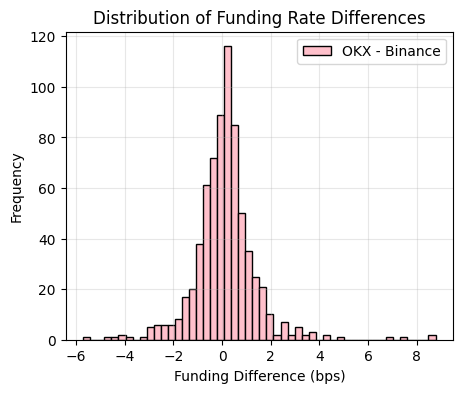

In [13]:
diffs_bps = merged_data['funding_diff'] * 10_000  # Convert to basis points
print(f'Mean funding differential: {diffs_bps.mean():.2f} bps')
plt.figure(figsize=(5, 4))
plt.hist(diffs_bps, bins=50, color='pink', edgecolor='black', label='OKX - Binance')
plt.xlabel('Funding Difference (bps)')
plt.ylabel('Frequency')
plt.title('Distribution of Funding Rate Differences')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

### <center> **Explanatory Features**

In [14]:
aligned_bnb = prepare_funding_times(binance_data['BNBUSDT'], okx)

In [15]:
# Calculate OI volatility using rolling window
merged_data['oi_volatility'] = merged_data['sum_open_interest'].pct_change().rolling(3).std() * 100
merged_data['oi_volatility'] = (np.log(merged_data['sum_open_interest']).pct_change().rolling(3).std() * 100)


# We create lag/lead columns
lags = [1, 2, 3]
for lag in lags:
    merged_data[f'sum_open_interest_lag{lag}'] = merged_data['sum_open_interest'].shift(lag)
    merged_data[f'pre_settle_oi_change_pct_lag{lag}'] = merged_data['pre_settle_oi_change_pct'].shift(lag)
    merged_data[f'oi_volatility_lag{lag}'] = merged_data['oi_volatility'].shift(lag)

# Then we create lead columns for the funding differential
for lead in [1, 2, 3]:
    merged_data[f'funding_diff_lead{lead}'] = merged_data['funding_diff'].shift(-lead)

merged_data.dropna(inplace=True)

In [16]:
# Let's define our features and target variables
features = [
    'funding_diff',             # Current funding differential
    'abs_diff',                 # Absolute funding differential
    'sum_open_interest',        # Current OI level
    'pre_settle_oi_mean',       # Pre-settlement OI average
    'pre_settle_oi_std',        # Pre-settlement OI standard deviation
    'pre_settle_oi_change_pct', # Pre-settlement OI percent change
    'oi_volatility',            # OI volatility
]

In [17]:
# Define target variables
targets = [f'funding_diff_lead{lead}' for lead in [1, 2, 3]]

# Explanatory features
features = [
    'funding_diff',             # Current funding differential
    'abs_diff',                 # Absolute funding differential
    'sum_open_interest',        # Current OI level
    'pre_settle_oi_mean',       # Pre-settlement OI average
    'pre_settle_oi_std',        # Pre-settlement OI standard deviation
    'pre_settle_oi_change_pct', # Pre-settlement OI percent change
    'oi_volatility',            # OI volatility
]

# Add lagged features
lag_features = []
for lag in [1, 2, 3]:
    lag_features.extend([
        f'sum_open_interest_lag{lag}',
        f'pre_settle_oi_change_pct_lag{lag}',
        f'oi_volatility_lag{lag}'
    ])

# Combine current and lagged features
all_features = features + lag_features

# Create correlation table between each feature and each target
correlation_table = pd.DataFrame(index=all_features)
for target in targets:
    correlation_table[target] = [
        merged_data[feature].corr(merged_data[target])
        for feature in all_features
    ]

print(correlation_table)

                               funding_diff_lead1  funding_diff_lead2  funding_diff_lead3
funding_diff                             0.228963            0.142763            0.168616
abs_diff                                 0.069814            0.004834           -0.009814
sum_open_interest                        0.110788            0.107277            0.113253
pre_settle_oi_mean                       0.106623            0.114988            0.111999
pre_settle_oi_std                        0.106081            0.074165            0.106794
pre_settle_oi_change_pct                 0.017000           -0.045641           -0.008777
oi_volatility                            0.048809            0.015413            0.051920
sum_open_interest_lag1                   0.106527            0.113710            0.109325
pre_settle_oi_change_pct_lag1           -0.046589           -0.000476           -0.009836
oi_volatility_lag1                       0.022617            0.005703            0.069964
sum_open_i

Funding Differential is the strongest predictor overall at 0.23 correlation with next period. The pattern somewhat suggests funding inefficiencies persist for multiple periods.

We see with the low absolute difference that direction matters more than magnitude.

The open interest is remarkably consistent at 0.11 across all time horizons, suggesting that OI provides a somewhat reliable secondary signal.

Let's create some more interesting features instead.

Top 10 features for predicting next funding differential:
funding_diff_X_pre_settle_std     0.263104
funding_diff_X_oi                 0.241677
funding_diff_X_pre_settle_mean    0.241429
log_funding_diff                  0.228966
funding_diff                      0.228963
funding_diff_X_volatility         0.219124
Name: funding_diff_lead1, dtype: float64


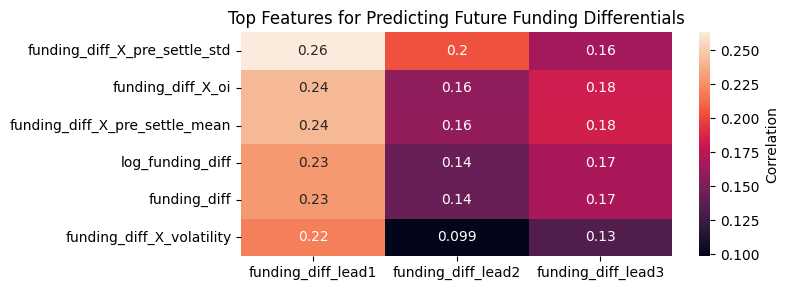

In [18]:
# Create transformed features
def add_transformations(df):
    transformed_df = df.copy()
    
    # Log transformation (handle negative values with sign preservation)
    for feature in ['funding_diff', 'pre_settle_oi_change_pct']:
        transformed_df[f'log_{feature}'] = np.sign(df[feature]) * np.log1p(np.abs(df[feature]))
    
    # Square root transformation (handle negative values with sign preservation)
    for feature in ['funding_diff', 'pre_settle_oi_change_pct']:
        transformed_df[f'sqrt_{feature}'] = np.sign(df[feature]) * np.sqrt(np.abs(df[feature]))
    
    # Squared features
    for feature in ['funding_diff', 'sum_open_interest', 'oi_volatility']:
        transformed_df[f'{feature}_squared'] = df[feature] ** 2
    
    # Interaction terms
    transformed_df['funding_diff_X_oi'] = df['funding_diff'] * df['sum_open_interest']
    transformed_df['funding_diff_X_volatility'] = df['funding_diff'] * df['oi_volatility']
    transformed_df['funding_diff_X_pre_settle_std'] = df['funding_diff'] * df['pre_settle_oi_std']
    transformed_df['funding_diff_X_pre_settle_mean'] = df['funding_diff'] * df['pre_settle_oi_mean']
    
    return transformed_df

merged_data = add_transformations(merged_data)

# Update feature list with transformed features
transformed_features = [
    'log_funding_diff', 'sqrt_funding_diff', 'funding_diff_squared',
    'log_pre_settle_oi_change_pct', 'sqrt_pre_settle_oi_change_pct',
    'sum_open_interest_squared', 'oi_volatility_squared',
    'funding_diff_X_oi', 'funding_diff_X_volatility',
    'funding_diff_X_pre_settle_std', 'funding_diff_X_pre_settle_mean'
]

# Combine with original features
all_features_enhanced = all_features + transformed_features

# Create volatility features with different window sizes
window_sizes = [2, 5, 8, 13, 21]  # Try Fibonacci sequence for windows, for fun

for window in window_sizes:
    merged_data[f'oi_volatility_window{window}'] = (
        merged_data['sum_open_interest']
        .pct_change()
        .rolling(window)
        .std() * 100
    )
    
    # Create lagged versions
    for lag in [1, 2, 3]:
        merged_data[f'oi_volatility_window{window}_lag{lag}'] = (
            merged_data[f'oi_volatility_window{window}']
            .shift(lag)
        )

# Add these to features list
volatility_features = [f'oi_volatility_window{w}' for w in window_sizes]
volatility_lag_features = [f'oi_volatility_window{w}_lag{lag}' 
                           for w in window_sizes 
                           for lag in [1, 2, 3]]

# Update feature list
all_features_enhanced += volatility_features + volatility_lag_features

# Create updated correlation table using merged_data (which now contains all features)
enhanced_correlation_table = pd.DataFrame(index=all_features_enhanced)

for target in targets:
    enhanced_correlation_table[target] = [
        merged_data[feature].corr(merged_data[target]) 
        for feature in all_features_enhanced
    ]

# Find top new features based on absolute correlation with the next funding rate differential
top_new_features = enhanced_correlation_table['funding_diff_lead1'].nlargest(6)
print("Top 10 features for predicting next funding differential:")
print(top_new_features)

plt.figure(figsize=(8, 3))
top_features_df = enhanced_correlation_table.loc[top_new_features.index]
sns.heatmap(top_features_df, annot=True, cbar_kws={'label': 'Correlation'})
plt.title('Top Features for Predicting Future Funding Differentials')
plt.tight_layout()
# plt.savefig('correlation.pdf', format='pdf')
plt.show()

The interaction between funding differential and open interest comes out as the strongest predictor with 0.24 correlation. This suggests that funding inefficiencies are most exploitable when they occur in markets with substantial open interest. Therefore, we should scale position size with both funding differentials and open interest. Like $\text{Position Size} \propto \text{Base Size} \cdot \{\text{funding\_diff} \times \text{OI}\}$.

Further, the strong performance of `funding_diff_X_volatility` indicates that market volatility affects how funding differentials persist. Therefore, our strategy should incorporate OI volatility as a conditioning variable, and the strategy might benefit from regime-based rules that adapt to volatility levels.

Based on these findings, our strategy should

1. Open positions when funding_diff × open_interest exceeds a threshold calibrated to transaction costs.
2. Scale position size proportionally to the strength of this interaction.
3. Target exit after capturing the next funding payment
4. Adjust exposure during high OI volatility periods
5. Prioritize pairs where we observed the largest and most persistent differentials

We can probably think about volatility in the following way.
- When volatility is very low, we consider a small downward adjustment since opportunities may be too crowded.
- When volatility is moderate, we maintain the size determined by the OI interaction.
- When volatility is very high, we cap position size to limit unexpected risks, such as liquidations and quick reversals.

### <center> **Continuing Examining the Signal**

Volatility Thresholds:
25th percentile: 0.0258
50th percentile: 0.0463
75th percentile: 0.0879
90th percentile: 0.1578

Combined Signal (|funding_diff| * OI) Statistics:
count      696.000000
mean      1022.501635
std       1267.323868
min          1.206605
25%        295.274446
50%        649.603282
75%       1264.503676
max      13310.194719
Name: combined_signal, dtype: float64
Median: 649.603

Correlation between combined signal and next period differential: 0.3495

Correlation between directional signal and next period differential: 0.3495

Funding Rate Persistence by Volatility Regime:
Low Volatility:
  Lag 1 persistence: 0.2097
  Lag 2 persistence: 0.1526
Medium Volatility:
  Lag 1 persistence: 0.2125
  Lag 2 persistence: 0.1674
High Volatility:
  Lag 1 persistence: 0.2504
  Lag 2 persistence: 0.1014


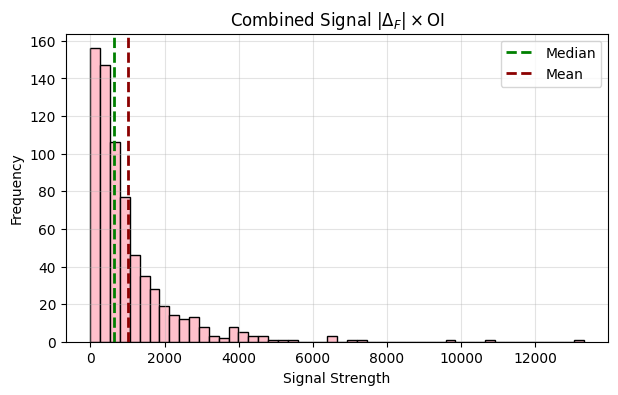

In [19]:
# Calculate volatility percentiles
vol_25th = merged_data['oi_volatility'].quantile(0.25)
vol_50th = merged_data['oi_volatility'].quantile(0.50)
vol_75th = merged_data['oi_volatility'].quantile(0.75)
vol_90th = merged_data['oi_volatility'].quantile(0.90)

print("Volatility Thresholds:")
print(f"25th percentile: {vol_25th:.4f}")
print(f"50th percentile: {vol_50th:.4f}")
print(f"75th percentile: {vol_75th:.4f}")
print(f"90th percentile: {vol_90th:.4f}")

# Calculate combined signal
merged_data['combined_signal'] = merged_data['funding_diff'].abs() * merged_data['sum_open_interest'] # Magnitude for position sizing
merged_data['directional_signal'] = merged_data['funding_diff'] * merged_data['sum_open_interest']    # Sign information in signal

print("\nCombined Signal (|funding_diff| * OI) Statistics:")
print(merged_data['combined_signal'].describe())
print(f"Median: {merged_data['combined_signal'].median():.3f}")

# Signal relationship with future differentials
signal_corr = merged_data['combined_signal'].corr(merged_data['funding_diff_lead1'].abs())
print(f"\nCorrelation between combined signal and next period differential: {signal_corr:.4f}")

directional_signal_corr = merged_data['directional_signal'].corr(merged_data['funding_diff_lead1'])
print(f"\nCorrelation between directional signal and next period differential: {signal_corr:.4f}")

# Volatility regimes
merged_data['vol_regime'] = pd.cut(
    merged_data['oi_volatility'],
    bins=[0, vol_25th, vol_75th, float('inf')],
    labels=['Low', 'Medium', 'High']
)

# Funding rate persistence varies by volatility regime
print("\nFunding Rate Persistence by Volatility Regime:")
for regime in ['Low', 'Medium', 'High']:
    regime_data = merged_data[merged_data['vol_regime'] == regime]
    lag1_corr = regime_data['funding_diff'].corr(regime_data['funding_diff_lead1'])
    lag2_corr = regime_data['funding_diff'].corr(regime_data['funding_diff_lead2'])
    
    print(f"{regime} Volatility:")
    print(f"  Lag 1 persistence: {lag1_corr:.4f}")
    print(f"  Lag 2 persistence: {lag2_corr:.4f}")

plt.figure(figsize=(7, 4))
plt.hist(merged_data['combined_signal'], color='pink', edgecolor='black', bins=50)
plt.axvline(merged_data['combined_signal'].median(), ls='--', lw=2, label='Median', color='green')
plt.axvline(merged_data['combined_signal'].mean(), ls='--', lw=2, label='Mean', color='darkred')
plt.title(r"Combined Signal $|\Delta_F| \times \text{OI}$")
plt.xlabel('Signal Strength')
plt.ylabel('Frequency')
plt.grid(alpha=0.35)
plt.legend()
# plt.savefig('singal_strength.pdf', format='pdf')
plt.show()

**Signal Interpretation**

The signal tells us the following:
- A signal of ~650 (median) represents an average opportunity
- A signal of ~1300 (75th percentile) represents an strong opportunity
- A signal of ~300 (25th percentile) represents a weak opportunity

For example, if we set our base position size at $10,000 for an average opportunity

- When signal = 650 (median): $10,000 position
- When signal = 1300 ($2 \times$ median): $20,000 position
- When signal = 325 ($0.5 \times$ median): $5,000 position

**Volatility Intepretation**

The volatiltiy values give us concrete thresholds for our position sizing adjustments. For example, if we have `adjusted_position_size = base_position_size × volatility_multiplier`
- In low volatility: $10,000 × 0.9 = $9,000
- In medium volatility: $10,000 × 1.0 = $10,000
- In high volatility: $10,000 × 0.7 = $7,000
- In extreme volatility: $10,000 × 0.5 = $5,000

High volatility regimes showed stronger short-term persistence but weaker long-term persistence.

Higher volatility periods have
- Greater execution risk (slippage, partial fills)
- Higher likelihood of sudden regime changes
- Increased chance of funding differential reversals

 By reducing size in high volatility and maintaining full size in medium volatility, we optimize capital allocation for the risk-reward profile of each market state

The funding_diff $\times$ OI signal shows significant skew, suggesting occasional extreme opportunities that we should capitalize on. It would be nice to normalize against the median rather than mean for more stable sizing.

In [20]:
def calculate_fee_tier_multipliers(fee_schedules, max_multiplier):
    """
    Calculate position size multipliers based on actual fee structures
    """
    # We're making on OKX and taking on Binance
    binance_taker = fee_schedules['binance_taker']
    okx_maker = fee_schedules['okx_maker']
    
    # Calculate total fees for each tier
    total_fees = []
    for i in range(min(len(binance_taker), len(okx_maker))):
        total_fee = (binance_taker[i] + okx_maker[i]) / 100  # Convert to decimal
        total_fees.append(total_fee)
    
    # Highest fee, regular user serves as the baseline
    base_fee = total_fees[0]
    
    multipliers = {}
    for i, fee in enumerate(total_fees):
        # Avoid division by zero for negative fees
        if fee <= 0:
            # Cap the advantage for negative fees
            multipliers[i] = max_multiplier
        else:
            multipliers[i]  = base_fee / fee
    
    return multipliers, total_fees

In [21]:
fee_schedules = {
    'binance_maker': binance_fees_maker,
    'binance_taker': binance_fees_taker,
    'okx_maker': okx_fees_maker,
    'okx_taker': okx_fees_taker
}

fee_multipliers, total_fees = calculate_fee_tier_multipliers(fee_schedules, max_multiplier=10)

print(f"{'Tier':<8} {'Total Fee %':<15} {'Multiplier':<12} {'Notes'}")
print("-" * 62)
for tier, multiplier in fee_multipliers.items():
    note = ""
    if tier == 0:
        note = "Baseline (Regular User)"
    elif multiplier > 3:
        note = "Strong capital advantage"
    
    print(f"{tier:<8} {total_fees[tier]*100:<15.3f} {multiplier:<12.2f} {note}")
print("-" * 62)

Tier     Total Fee %     Multiplier   Notes
--------------------------------------------------------------
0        0.130           1.00         Baseline (Regular User)
1        0.085           1.53         
2        0.075           1.73         
3        0.062           2.10         
4        0.050           2.60         
5        0.027           4.81         Strong capital advantage
6        0.023           5.65         Strong capital advantage
7        0.017           7.65         Strong capital advantage
8        0.015           8.67         Strong capital advantage
--------------------------------------------------------------


In [40]:
def calculate_position_size(funding_diff, open_interest, volatility, account_size, risk_factor, fee_tier, max_percentage):
    """Calculate position size based on market signals and account parameters"""
    
    # Signal strength calculation
    signal = abs(funding_diff) * open_interest
    signal_ratio = signal / 652  # Normalized to median signal from our analysis
    
    # Volatility adjustment
    if volatility < 0.41:  # Low volatility
        vol_multiplier = 0.9
    elif volatility < 1.42:  # Medium volatility
        vol_multiplier = 1.0
    elif volatility < 2.56:  # High volatility
        vol_multiplier = 0.7
    else:  # Extreme volatility
        vol_multiplier = 0.5
        
    fee_multiplier = fee_multipliers.get(fee_tier)
    
    # Base position size (% of account)
    base_size = account_size * risk_factor
    
    # Apply multipliers
    adjusted_size = base_size * signal_ratio * vol_multiplier * fee_multiplier
    
    # Apply maximum position constraint as % of account
    max_position = account_size * max_percentage
    position_size = min(adjusted_size, max_position)
    
    return position_size

In [23]:
# Trade scenario
funding_diff = 0.0002
open_interest = 13_567_016      # Example open interest
volatility = 0.9                # Medium volatility or 265890
account_size = 100_000          # $100k account
risk_factor = 0.01              # % risk per unit of signal
fee_tier = 8

# Calculate position size
position = calculate_position_size(funding_diff, open_interest, volatility, account_size, risk_factor, fee_tier)

print(f"Inputs")
print(f"Funding Differential: {funding_diff * 10_000:.2f} bps")
print(f"Open Interest: {open_interest}")
print(f"Volatility: {volatility:.2f}")
print(f"Signal Strength: {abs(funding_diff) * open_interest:.2f}")
print(f"Signal Ratio: {(funding_diff * open_interest) / merged_data['combined_signal'].median():.2f}x median")
print(f"Fee Tier: {fee_tier} (multiplier: {fee_multipliers[fee_tier]:.2f}x)")
print(f"\nPosition Size: ${position:.2f}")

Inputs
Funding Differential: 2.00 bps
Open Interest: 13567016
Volatility: 0.90
Signal Strength: 2713.40
Signal Ratio: 4.18x median
Fee Tier: 8 (multiplier: 8.67x)

Position Size: $10000.00


### <center> **Execution Analysis**

In [24]:
# Order book snapshot data
binance_bnb_lob = pd.read_csv('./data/BNBUSDT_orderbook_snapshot.csv')
okx_bnb_lob = pd.read_csv('./data/BNBUSDT_orderbook_snapshot_okx.csv')

print(binance_bnb_lob.transpose())

                                             0
Unnamed: 0                                   0
instrument                             BNBUSDT
time          2025-03-23T20:57:02.585021+00:00
BidPrice_1                              623.01
BidVolume_1                               12.6
BidPrice_2                               623.0
BidVolume_2                              29.22
BidPrice_3                              622.99
BidVolume_3                               24.3
BidPrice_4                              622.98
BidVolume_4                               4.07
BidPrice_5                              622.97
BidVolume_5                               4.68
BidPrice_6                              622.96
BidVolume_6                               3.67
BidPrice_7                              622.95
BidVolume_7                              22.04
BidPrice_8                              622.94
BidVolume_8                                6.0
BidPrice_9                              622.93
BidVolume_9  

Let's first compute the expected price impact for different order sizes on both exchanges

In [25]:
def calculate_execution_impact(orderbook_df, order_size, side):
    """Calculate price impact for a given order size"""
    cum_volume = 0
    weighted_price = 0
    
    if side == "buy": # Buy from the ask side
        price_cols = [f'AskPrice_{i}' for i in range(1, 11)]
        volume_cols = [f'AskVolume_{i}' for i in range(1, 11)]
    elif side == "sell": # Sell to the bid side
        price_cols = [f'BidPrice_{i}' for i in range(1, 11)]
        volume_cols = [f'BidVolume_{i}' for i in range(1, 11)]
    
    # Iterate through price levels
    for price_col, volume_col in zip(price_cols, volume_cols):
        price = orderbook_df[price_col].values[0]
        volume = orderbook_df[volume_col].values[0]
        
        if cum_volume + volume >= order_size:
            # This level completes our order
            remaining = order_size - cum_volume
            weighted_price += price * remaining
            cum_volume = order_size
            break
        else:
            # Absorb full volume at this level and continue to the next
            weighted_price += price * volume
            cum_volume += volume
    
    if cum_volume < order_size:
        return None  # Not enough liquidity
    
    vwap = weighted_price / order_size
    mid_price = orderbook_df['MidPrice'].values[0]
    
    # Dollar value
    position_value_usd = vwap * order_size
    mid_value_usd = mid_price * order_size
    dollar_impact = position_value_usd - mid_value_usd if side == "buy" else mid_value_usd - position_value_usd
    
    return {
        'average_price': vwap,
        'mid_price': mid_price,
        'price_impact_bps': (vwap / mid_price - 1) * 10_000 if side == "buy" 
                            else (mid_price / vwap - 1) * 10_000,
        'position_value_usd': position_value_usd,
        'dollar_impact': dollar_impact
    }

In [26]:
# Calculate impact for different sizes
sizes = [5, 10, 15, 20, 50]
results = []

for size in sizes:
    binance_impact = calculate_execution_impact(binance_bnb_lob, size, "sell")
    okx_impact = calculate_execution_impact(okx_bnb_lob, size, "buy")
    
    if binance_impact and okx_impact:
        results.append({
            'size_bnb': size,
            'binance_impact_bps': binance_impact['price_impact_bps'],
            'okx_impact_bps': okx_impact['price_impact_bps'],
            'binance_value_usd': binance_impact['position_value_usd'],
            'okx_value_usd': okx_impact['position_value_usd'],
            'binance_dollar_impact': binance_impact['dollar_impact'],
            'okx_dollar_impact': okx_impact['dollar_impact'],
            'total_position_value': binance_impact['position_value_usd'] + okx_impact['position_value_usd'],
        })

impact_df = pd.DataFrame(results)
print(impact_df)

   size_bnb  binance_impact_bps  okx_impact_bps  binance_value_usd  okx_value_usd  binance_dollar_impact  okx_dollar_impact  total_position_value
0         5            0.080256        0.801989          3115.0500    3117.500000                 0.0250           0.250000           6232.550000
1        10            0.080256        1.154885          6230.1000    6235.220013                 0.0500           0.720013          12465.320013
2        15            0.105938        1.571912          9345.1260    9353.220013                 0.0990           1.470013          18698.346013
3        20            0.139645        1.780426         12460.1260   12471.220013                 0.1740           2.220013          24931.346013
4        50            0.226581        3.379107         31150.0442   31183.033521                 0.7058          10.533521          62333.077721


Our execution analysis confirms our original approach: make on OKX and take on Binance. This is optimal because OKX shows significantly higher market impact, meaning we should avoid taking there if possible. By placing limit orders on OKX, we can gradually build our position without causing adverse price movements, while immediately hedging each fill with a corresponding market order on Binance. This leverages OKX's negative maker fees at better fee tiers.

We also see that we should keep order chunks around 10 - 15 BNB, around $12,500 - $18,700 positional value, where execution impacts are manageable.

The non-linear scaling of impact is also interesting.

Now the model scales positions based on signal strength while accounting for volatility and fee advantages. In this case, even with excellent fee terms, the weak funding differential keeps the position appropriately small.

Let's continue by developing the order execution component. This will define how we will implement trades once we have determined the appropriate position size.

In [27]:
def create_execution_plan(position_size_usd, current_price, max_chunk_size):
    """
    Create a execution plan
    """
    # Convert USD to BNB
    position_size_bnb = position_size_usd / current_price
    position_size_bnb = round(position_size_bnb, 2)
    
    # Break into chunks for optimal execution
    chunks = []
    remaining = position_size_bnb
    
    while remaining > 0:
        if remaining > max_chunk_size:
            chunks.append(max_chunk_size)
            remaining -= max_chunk_size
        else:
            # Ensure minimum viable order size 0.1 BNB
            if remaining >= 0.1:  
                chunks.append(round(remaining, 2))
            remaining = 0
    
    
    # Create detailed execution steps
    execution_steps = []
    for i, chunk in enumerate(chunks):
        execution_steps.append({
            'step': i + 1,
            'action': 'Place limit order on OKX',
            'size_bnb': chunk,
            'side': 'BUY',
            'price': 'Best Ask - 0.01',
            'expected_value_usd': round(chunk * current_price, 2)
        })
        
        execution_steps.append({
            'step': i + 1.5,  # Intermediate step
            'action': 'After OKX fill, immediately hedge on Binance',
            'size_bnb': chunk,
            'side': 'SELL',
            'price': 'Market Order',
            'expected_value_usd': round(chunk * current_price, 2)
        })
    
    return {
        'position_size_usd': position_size_usd,
        'position_size_bnb': position_size_bnb,
        'number_of_chunks': len(chunks),
        'chunks': chunks,
        'execution_steps': execution_steps,
    }

In [28]:
# Test with a concrete example
current_price = 623.0
position_size_usd = 15_000.0

execution_plan = create_execution_plan(position_size_usd, current_price, max_chunk_size=5)

print(f"Execution Plan for ${position_size_usd:.2f} position:")
print(f"Total position: {execution_plan['position_size_bnb']} BNB")
print(f"Number of chunks: {execution_plan['number_of_chunks']}")
print(f"Chunk sizes: {execution_plan['chunks']}")

Execution Plan for $15000.00 position:
Total position: 24.08 BNB
Number of chunks: 5
Chunk sizes: [5, 5, 5, 5, 4.08]


### <center> **Convergence Analysis**

Let's explore how long it takes for the funding differential to converge on average

In [29]:
def analyze_differential_convergence(funding_data, threshold_pct):
    """
    Analyze how long it takes for funding differentials to converge by threshold percentage
    """
    convergence_periods = []
    
    # Iterate through each starting point
    for i in range(len(funding_data) - 20):  # Look up to 20 periods ahead
        initial_diff = funding_data['funding_diff'].iloc[i]
        
        # Skip very small initial differentials
        if abs(initial_diff) < 0.00001:
            continue
            
        # Calculate target threshold based on initial differential
        target_threshold = initial_diff * (1 - threshold_pct / 100) if initial_diff > 0 else initial_diff * (1 + threshold_pct / 100)
        
        # Find when differential crosses target threshold
        for j in range(1, min(20, len(funding_data) - i)):
            current_diff = funding_data['funding_diff'].iloc[i + j]
            
            # Check if differential has converged by threshold
            if (initial_diff > 0 and current_diff <= target_threshold) or \
               (initial_diff < 0 and current_diff >= target_threshold):
                convergence_periods.append({
                    'start_date': funding_data.index[i],
                    'initial_diff': initial_diff,
                    'periods_to_converge': j,
                    'initial_diff_bps': initial_diff * 10_000,  # Convert to basis points,
                    'end_diff': current_diff,
                    'pct_reduction': abs(1 - current_diff / initial_diff) * 100
                })
                break
    
    return pd.DataFrame(convergence_periods)

In [30]:
# Iterate through each starting point in the BNB dataset
bnb_data = symbols_data['BNB-USDT-SWAP'].copy()

convergence_df = analyze_differential_convergence(bnb_data, threshold_pct=100) # We compute convergence as 100%

# Calculate basic statistics
mean_periods = convergence_df['periods_to_converge'].mean()
median_periods = convergence_df['periods_to_converge'].median()
min_periods = convergence_df['periods_to_converge'].min()
max_periods = convergence_df['periods_to_converge'].max()

print(f"Convergence Analysis:")
print(f"Mean convergence time: {mean_periods:.2f} periods")
print(f"Median convergence time: {median_periods:.2f} periods")
print(f"Range: {min_periods} to {max_periods} periods")
print(f"Total convergence events observed: {len(convergence_df)}")


Convergence Analysis:
Mean convergence time: 2.12 periods
Median convergence time: 1.00 periods
Range: 1 to 14 periods
Total convergence events observed: 650


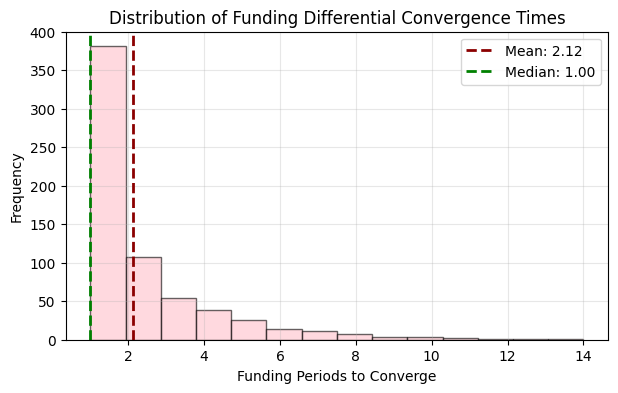

In [31]:
# Plot distribution of convergence periods
plt.figure(figsize=(7, 4))
plt.hist(convergence_df['periods_to_converge'], color='pink', alpha=0.6, edgecolor='black', bins=14)

plt.axvline(mean_periods, color='darkred', lw=2, ls='--', label=f'Mean: {mean_periods:.2f}')
plt.axvline(median_periods, color='green', lw=2, ls='--', label=f'Median: {median_periods:.2f}')

plt.xlabel('Funding Periods to Converge')
plt.ylabel('Frequency')
plt.title('Distribution of Funding Differential Convergence Times')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('convergence_times.pdf', format='pdf')
plt.show()

The differential seems to dissapear pretty quickly in most cases, holding only for about a period. We can also use this as help for determining the optimal exit.

In [32]:
# Test scenario for different funding differentials
funding_diffs = [0.5, 1.0, 3.0, 7.0]  # in basis points

maker_fee = okx_fees_maker[8]
taker_fee = binance_fees_taker[9]

# A test order size
test_size = 15  # BNB

# Impact for given size
binance_impact = calculate_execution_impact(
    binance_bnb_lob, 
    test_size, 
    "sell"  # Sell on Binance, taker side
)

# Costs
fee_cost_pct = (maker_fee + taker_fee) / 100
execution_cost_bps = binance_impact['price_impact_bps']
execution_cost_pct = execution_cost_bps / 10_000
total_cost_pct = fee_cost_pct + execution_cost_pct

# Calculate break-even funding differential
# We multiply by 2 because we need to cover round-trip costs
breakeven_funding_bps = (2 * total_cost_pct) * 10_000

print(f"Cost Analysis:")
print(f"Fee cost: {fee_cost_pct * 100:.4f}%")
print(f"Execution cost: {execution_cost_bps:.2f} bps")
print(f"Total round-trip cost: {(2 * total_cost_pct) * 100:.4f}%")
print(f"Break-even funding differential: {breakeven_funding_bps:.2f} bps")

print(f"Mean time to convergence: {mean_periods:.2f} periods")
print(f"Median time to convergence: {median_periods:.2f} periods")

# Evaluate each scenario
print("\nOpportunity Analysis:")
for diff in funding_diffs:
    # Calculate breakeven periods needed
    breakeven_periods = (2 * total_cost_pct) / (diff / 10_000)
    
    # Calculate expected profit per $1000
    expected_profit = (diff / 10_000 - 2 * total_cost_pct) * 1000
    
    # Decision rules
    profitable = diff > breakeven_funding_bps
    single_period_profitable = breakeven_periods <= 1.0
    
    print(f"\n{diff} bps funding differential:")
    print(f"    Break-even periods: {breakeven_periods:.2f}")
    print(f"    Expected profit per $1000: ${expected_profit:.2f}")

Cost Analysis:
Fee cost: 0.0120%
Execution cost: 0.11 bps
Total round-trip cost: 0.0261%
Break-even funding differential: 2.61 bps
Mean time to convergence: 2.12 periods
Median time to convergence: 1.00 periods

Opportunity Analysis:

0.5 bps funding differential:
    Break-even periods: 5.22
    Expected profit per $1000: $-0.21

1.0 bps funding differential:
    Break-even periods: 2.61
    Expected profit per $1000: $-0.16

3.0 bps funding differential:
    Break-even periods: 0.87
    Expected profit per $1000: $0.04

7.0 bps funding differential:
    Break-even periods: 0.37
    Expected profit per $1000: $0.44


### <center> **Risk Management Approach**
We will use a simple risk management system to keep our strategy safe while still making good profits. Here's what we will do:


We will adjust how much leverage we use based on market conditions

- When markets are calm, low volatility, use up to 7x leverage
- During normal markets, use up to 5x leverage
- When markets are jumpy high volatility, limit ourselves to just 3x leverage

We will also use more leverage when funding differentials are bigger, since we want to print when we have greater opportunities.


We will keep extra margin in our accounts - at least 3 times what exchanges require as a minimum. This should gives us plenty of room for safety.
We will need automatic safety triggers
- If we use 70% of our safety buffer, reduce our position by 20%
- If we use 85% of our buffer, cut our position in half
- If we use 95% of our buffer, close everything to avoid liquidation

- Move extra money between exchanges as needed. When one leg trade is profitable, we'll transfer some of that profit to support the losing leg.
- Use unified margin accounts whenever exchanges offer them, as they let us use our capital more efficiently.
- Spread our trades across different coin pairs rather than putting everything in one trade. No single pair will get more than 20% of our total money.
- Balance our positions on each exchange so we're not too exposed to big market swings in either direction.

### <center> **Backtest Assumptions & Limitations**

Because we lack genuine out-of-sample open interest data, we substitute either the last known or the average in-sample open interest to calculate signals in the OOS period. As a result, any feature derived from open interest (including volatility) is not truly representative of the real market environment during that timeframe.

Additionally, the thresholds for volatility regimes were computed on in-sample data and applied out of sample. If actual volatility conditions changed, this classification could become inaccurate. We also use a single snapshot of the order book to estimate slippage, which is inaccurate for the OOS period. In practice, liquidity and market impact vary over time.

We hold positions for exactly one funding interval, entering on a high funding differential and exiting on the next settlement. This simple approach does not account for partial fills, dynamic readjustments if fills are slow or incomplete, or real-time updates to margin usage. Finally, we rely on best tier fees, which may not be available.

Overall, these assumptions mean the backtest overstates performance. It serves primarily as a demonstration of how to structure a basic PnL simulation, rather than a indicator of live trading results.

In [34]:
# Load out of sample data to backtest on

# OKX data
okx_oos = pd.read_csv(r'C:\Users\trgrd\OneDrive\Trading\Projects\funding_arb\code\okx_swaprate_data\combined\allswaprate_2025-02-01_to_2025-03-26_raw.csv')

# Binance data
binance_oos = pd.read_parquet(f"./data/binance_funding_rate_BNBUSDT_ous.parquet")
binance_oos.set_index('fundingTime', inplace=True)
binance_oos['fundingRate'] = pd.to_numeric(binance_oos['fundingRate'], errors='coerce')

In [35]:
# Alignment
okx_oos = get_okx_funding_symbol('BNB-USDT-SWAP', okx_oos)
aligned_oos = prepare_funding_times(binance_oos, okx_oos)

In [36]:
# Create the out-of-sample dataframe
merged_data_oos = aligned_oos.copy()

merged_data_oos['oi_volatility'] = merged_data_oos['okx_rate'].pct_change().rolling(3).std() * 100
merged_data_oos['abs_diff'] = merged_data_oos['funding_diff'].abs()

# We need open interest data for the model
# Use the mean from our in-sample period
# This is bad but we have no other data
mean_oi = merged_data['sum_open_interest'].mean()
merged_data_oos['sum_open_interest'] = mean_oi

# Volatility regimes based on old data
vol_25th = merged_data['oi_volatility'].quantile(0.25)
vol_75th = merged_data['oi_volatility'].quantile(0.75)
merged_data_oos['vol_regime'] = pd.cut(
    merged_data_oos['oi_volatility'],
    bins=[0, vol_25th, vol_75th, float('inf')],
    labels=['Low', 'Medium', 'High']
)

for lead in [1, 2, 3]:
    merged_data_oos[f'funding_diff_lead{lead}'] = merged_data_oos['funding_diff'].shift(-lead)

merged_data_oos['combined_signal'] = merged_data_oos['funding_diff'].abs() * merged_data_oos['sum_open_interest']
merged_data_oos['directional_signal'] = merged_data_oos['funding_diff'] * merged_data_oos['sum_open_interest']

merged_data_oos.dropna(inplace=True)

print(f"Number of periods: {len(merged_data_oos)}")
print(f"Date range: {merged_data_oos.index.min()} to {merged_data_oos.index.max()}")
print(f"Average funding differential (bps): {merged_data_oos['funding_diff'].mean() * 10000:.2f}")

Number of periods: 153
Date range: 2025-02-02 00:00:00 to 2025-03-24 16:00:00
Average funding differential (bps): -0.29


Initial Estimated Transaction Costs:
Fee cost: 0.0120%
Execution cost: 0.11 bps
Total cost: 0.0131%
Break-even funding differential: 2.61 bps
Entry threshold: 0.00029

           entry_time           exit_time  entry_funding_diff  funding_payment  transaction_costs  position_size       pnl  account_equity
0 2025-02-10 00:00:00 2025-02-10 16:00:00           -3.870696         3.870696           2.881984   10000.000000  0.988712   100000.988712
1 2025-02-13 16:00:00 2025-02-14 08:00:00            4.273679         4.273722           2.629567   10000.098871  1.644155   100002.632867
2 2025-02-21 16:00:00 2025-02-22 08:00:00            3.033618         3.033698           2.629614   10000.263287  0.404084   100003.036951
3 2025-02-22 08:00:00 2025-02-23 00:00:00           -3.996877         3.996998           2.882091   10000.303695  1.114908   100004.151859
4 2025-02-24 00:00:00 2025-02-24 16:00:00            4.634414         4.634606           2.629658   10000.415186  2.004948   100006.15680

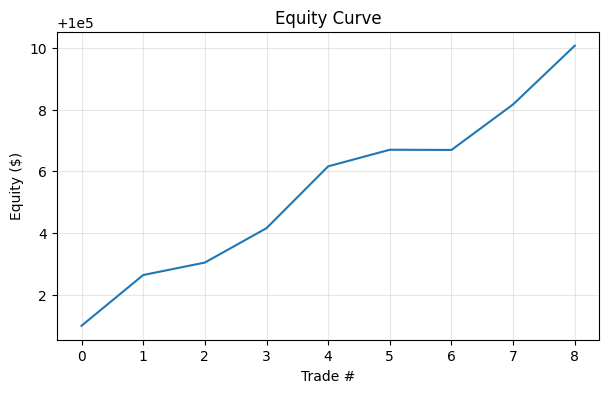

In [ ]:
# Setup and parameter definitions
initial_account = 100_000
risk_factor = 0.1
test_size = 15
max_percentage = 0.1

maker_fee = okx_fees_maker[8]
taker_fee = binance_fees_taker[9]
fee_cost_pct = (maker_fee + taker_fee) / 100

binance_impact = calculate_execution_impact(binance_bnb_lob, test_size, "sell")
execution_cost_bps = binance_impact['price_impact_bps']
execution_cost_pct = execution_cost_bps / 1e4

total_cost_pct = fee_cost_pct + execution_cost_pct
breakeven_funding_bps = (2 * total_cost_pct) * 1e4
entry_factor = 1.1
entry_threshold = (breakeven_funding_bps / 1e4) * entry_factor

print("Initial Estimated Transaction Costs:")
print(f"Fee cost: {fee_cost_pct * 100:.4f}%")
print(f"Execution cost: {execution_cost_bps:.2f} bps")
print(f"Total cost: {total_cost_pct * 100:.4f}%")
print(f"Break-even funding differential: {breakeven_funding_bps:.2f} bps")
print(f"Entry threshold: {entry_threshold:.5f}\n")

trade_logs = []
account_equity = initial_account
in_trade, position_size = False, 0
entry_time, entry_funding_diff = None, None

# Main backtest loop
for i in range(len(merged_data_oos) - 1):
    row = merged_data_oos.iloc[i]
    next_time = merged_data_oos.index[i + 1]

    # Enter trade
    if not in_trade:
        if abs(row['funding_diff']) > entry_threshold:
            pos_size = calculate_position_size(
                funding_diff=row['funding_diff'],
                open_interest=row['sum_open_interest'],
                volatility=row['oi_volatility'],
                account_size=account_equity,
                risk_factor=risk_factor,
                fee_tier=fee_tier,
                max_percentage=max_percentage
            )
            if pos_size > 1000:
                in_trade = True
                position_size = pos_size
                entry_time = merged_data_oos.index[i]
                entry_funding_diff = row['funding_diff']             
    else: # Exit trade
        funding_payment = position_size * abs(entry_funding_diff) # Our profit

        pos_size_bnb = position_size / current_price
        binance_side = "sell" if entry_funding_diff > 0 else "buy"

        exit_impact = calculate_execution_impact(binance_bnb_lob, pos_size_bnb, binance_side)
        exit_bps = exit_impact['price_impact_bps'] if exit_impact else execution_cost_bps * 2
        exit_pct = exit_bps / 1e4
        transaction_cost = position_size * (2 * fee_cost_pct + 2 * exit_pct)
        trade_pnl = funding_payment - transaction_cost
        account_equity += trade_pnl

        trade_logs.append({
            'entry_time': entry_time,
            'exit_time': next_time,
            'entry_funding_diff': entry_funding_diff * 1e4,
            'funding_payment': funding_payment,
            'transaction_costs': transaction_cost,
            'position_size': position_size,
            'pnl': trade_pnl,
            'account_equity': account_equity
        })
        in_trade = False

df = pd.DataFrame(trade_logs)
print(df, "\n")

total_return = (account_equity - initial_account) / initial_account * 100
num_trades = len(df)
avg_return = df['pnl'].mean() if num_trades else 0
std_return = df['pnl'].std() if num_trades > 1 else 0
sharpe = (avg_return / std_return) * np.sqrt(252*3) if std_return else float('nan')

df['equity_peak'] = df['account_equity'].cummax()
df['drawdown'] = df['account_equity'] - df['equity_peak']
df['drawdown_pct'] = 100 * (df['drawdown'] / df['equity_peak'])
max_dd = df['drawdown_pct'].min() if num_trades else 0

print(f"Total Return: {total_return:.2f}%")
print(f"Trades: {num_trades}")
print(f"Avg Trade PnL: ${avg_return:.2f}")
print(f"Annualized Sharpe: {sharpe:.2f}")
print(f"Max Drawdown: {max_dd:.2f}%")

plt.figure(figsize=(7, 4))
plt.plot(df.index, df['account_equity'])
plt.xlabel("Trade #")
plt.ylabel("Equity ($)")
plt.title("Equity Curve")
plt.grid(alpha=0.3)
plt.show()

These results are clearly overly optimistic